In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import datetime

pd.set_option('display.max_columns',None)
pd.set_option('display.min_rows',0)
pd.set_option('display.max_rows',None)

In [115]:
ip = pd.read_csv('../processed_data/ip_pt_pro.csv')
op = pd.read_csv('../processed_data/op_pt_pro.csv')
flags = pd.read_csv('../../../raw_data/Train-1542865627584.csv')

In [116]:
ip.head()

,Unnamed: 0,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ApproxAge,Diseases,Age,TotalReimbursement,PotentialFraud
0,0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,66,4,66,27068.0,Yes
1,1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,66,4,66,6068.0,No
2,2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,66,4,66,6068.0,No
3,3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1914-03-01,NaN,2,2,0,1,360,12,12,1,0,0,1,1,0,0,1,1,0,0,5000,1068,250,320,94,5,94,6068.0,No
4,4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1938-04-01,NaN,2,1,1,45,780,12,12,1,0,0,1,0,0,1,0,1,1,1,21260,2136,120,100,70,7,71,11068.0,No


In [117]:
# Converting dt columns from str to dt

def col_to_date(df, col_list) :
    for x in col_list:
        df[x] = pd.to_datetime(df[x])
    return df

dtcols_ip = ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','DOB']
ip = col_to_date(ip, dtcols_ip)

dtcols_op = ['ClaimStartDt','ClaimEndDt','DOB']
op = col_to_date(op, dtcols_op)

In [118]:
# Making IP/OP table

ip['Kind'] = 'IP'
op['Kind'] = 'OP'

ipop = pd.concat([ip, op], axis=0, sort=True)

In [119]:
print(len(ip))
print(len(op))
print(len(ipop))

40474
517737
558211


In [120]:
40474 + 517737

558211

## Average Duration

In [129]:
# Make duration column

ip['Duration'] = (ip['ClaimEndDt']-ip['ClaimStartDt']).dt.days
op['Duration'] = (op['ClaimEndDt']-op['ClaimStartDt']).dt.days
ipop['Duration'] = (ipop['ClaimEndDt']-ipop['ClaimStartDt']).dt.days

In [130]:
# Find average per provider

feat_duration_ip = ip.groupby('Provider')['Duration'].agg(['median','mean']).rename(columns={'median':'DurationMedianIP', 'mean':'DurationMeanIP'}).reset_index()
feat_duration_op = op.groupby('Provider')['Duration'].agg(['median','mean']).rename(columns={'median':'DurationMedianOP', 'mean':'DurationMeanOP'}).reset_index()
feat_duration_ipop = ipop.groupby('Provider')['Duration'].agg(['median','mean']).rename(columns={'median':'DurationMedianIP', 'mean':'DurationMeanOP'}).reset_index()
feat_duration_ip.head()

,Provider,DurationMedianIP,DurationMeanIP
0,PRV51001,4.0,5.000000
1,PRV51003,4.0,5.161290
2,PRV51007,5.0,5.333333
3,PRV51008,4.0,4.000000
4,PRV51011,5.0,5.000000


In [126]:
# Merge w/ flags

# feat_duration_ip = feat_duration_ip.merge(flags, how='left', on='Provider')
# feat_duration_op = feat_duration_ip.merge(flags, how='left', on='Provider')
# feat_duration_ip = feat_duration_ip.merge(flags, how='left', on='Provider')

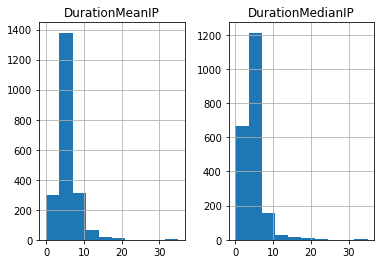

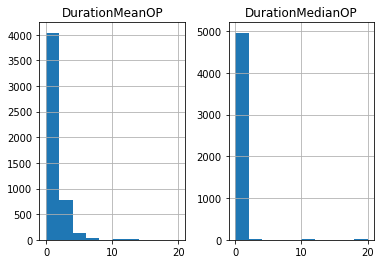

In [131]:
# Do we need an IP/OP split? Yes.

feat_duration_ip.hist()
plt.show()

feat_duration_op.hist()
plt.show()

In [191]:
# Making final feature

feat_duration_final = flags.merge(feat_duration_ip, how='left', on='Provider')
feat_duration_final = feat_duration_final.merge(feat_duration_op, how='left', on='Provider')

print(len(feat_duration_final))
feat_duration_final.head()

5410


,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP
0,PRV51001,No,4.0,5.000000,0.0,0.550000
1,PRV51003,Yes,4.0,5.161290,0.0,2.357143
2,PRV51004,No,NaN,NaN,0.0,1.429530
3,PRV51005,Yes,NaN,NaN,0.0,1.088412
4,PRV51007,No,5.0,5.333333,0.0,0.768116


## Hospitals that Serve Both IP and OP

In [23]:
# Make list of pros in ip and op separately

ip_pros = list(set(ip['Provider']))
op_pros = list(set(op['Provider']))

In [144]:
# Make df with IPs also in OP, and OPs also in IP, and then both!

ip_pros_df = pd.DataFrame(ip_pros, columns=['Provider'])
ip_pros_tf = ip_pros_df.isin(op_pros)
feat_both_ip = pd.concat([ip_pros_df, ip_pros_df.isin(op_pros).rename(columns={'Provider':'Serves'})], axis=1)
feat_both_ip['Serves'] = np.where(feat_both_ip['Serves']==0,'IP','Both')

op_pros_df = pd.DataFrame(op_pros, columns=['Provider'])
feat_both_op = pd.concat([op_pros_df, op_pros_df.isin(ip_pros).rename(columns={'Provider':'Serves'})], axis=1)
feat_both_op['Serves'] = np.where(feat_both_op['Serves']==0,'OP','Both')

feat_both_final = pd.concat([feat_both_ip, feat_both_op], axis=0, ignore_index=True).drop_duplicates()
feat_both_final = feat_both_final.merge(flags, on='Provider')

display(feat_both_ip.head())
display(feat_both_op.head())
feat_both_final.head()

,Provider,Serves
0,PRV55670,IP
1,PRV51030,Both
2,PRV57521,Both
3,PRV51851,Both
4,PRV57310,Both


,Provider,Serves
0,PRV57692,OP
1,PRV56156,Both
2,PRV54530,OP
3,PRV54997,Both
4,PRV52063,Both


,Provider,Serves,PotentialFraud
0,PRV55670,IP,Yes
1,PRV51030,Both,No
2,PRV57521,Both,No
3,PRV51851,Both,Yes
4,PRV57310,Both,Yes


In [143]:
print(len(feat_both_ip))
print(len(feat_both_op))
print(len(feat_both_final))

2092
5012
5410


## Number of Chronic Conditions per Pt

In [145]:
feat_conditions_ip = ip.groupby('Provider')['Diseases'].agg(['median','mean']).rename(columns={'median':'ChronCondsMedianIP', 'mean':'ChronCondsMeanIP'})
feat_conditions_ip['ChronConsModeIP'] = ip.groupby('Provider')['Diseases'].agg(pd.Series.mode)
feat_conditions_ip.reset_index(inplace=True)

feat_conditions_op = op.groupby('Provider')['Diseases'].agg(['median','mean']).rename(columns={'median':'ChronCondsMedianOP', 'mean':'ChronCondsMeanOP'})
feat_conditions_op['ChronConsModeOP'] = op.groupby('Provider')['Diseases'].agg(lambda x:x.value_counts().index[0])
feat_conditions_op.reset_index(inplace=True)

feat_conditions_ipop = ipop.groupby('Provider')['Diseases'].agg(['median','mean']).rename(columns={'median':'ChronCondsMedian', 'mean':'ChronCondsMean'})
feat_conditions_ipop['ChronConsMode'] = ipop.groupby('Provider')['Diseases'].agg(pd.Series.mode)
feat_conditions_ipop.reset_index(inplace=True)

feat_conditions_ip.head()

,Provider,ChronCondsMedianIP,ChronCondsMeanIP,ChronConsModeIP
0,PRV51001,5.0,5.400000,5
1,PRV51003,6.5,6.354839,7
2,PRV51007,6.0,5.666667,6
3,PRV51008,7.5,7.500000,"[7, 8]"
4,PRV51011,5.0,5.000000,5


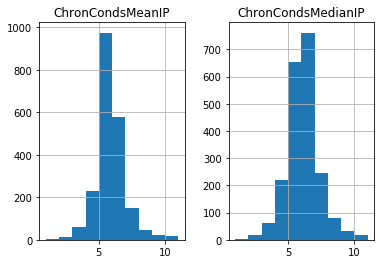

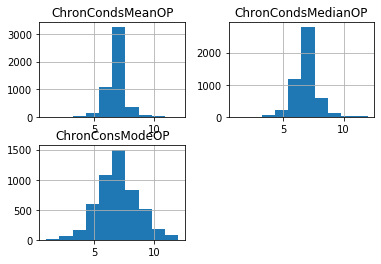

In [181]:
# Do we need an IP/OP split? No.

feat_conditions_ip.hist()
plt.show()

feat_conditions_op.hist()
plt.show()

In [190]:
# Making final feature

feat_conditions_final = flags.merge(feat_conditions_ipop, how='left', on='Provider')
feat_conditions_final['ChronConsMode'] = feat_conditions_final['ChronConsMode']\
    .apply(lambda x: x.mean() if type(x) != np.int64 else x)

print(len(feat_conditions_final))
feat_conditions_final.head(10)

5410


,Provider,PotentialFraud,ChronCondsMedian,ChronCondsMean,ChronConsMode
0,PRV51001,No,6.0,5.760000,5.000000
1,PRV51003,Yes,7.0,6.674242,6.000000
2,PRV51004,No,7.0,6.812081,8.000000
3,PRV51005,Yes,7.0,6.886695,5.000000
4,PRV51007,No,7.0,6.986111,6.000000
5,PRV51008,No,7.0,7.325581,7.000000
6,PRV51011,No,7.0,6.620690,5.500000
7,PRV51012,No,6.5,6.520833,4.000000
8,PRV51013,No,7.0,6.826087,8.000000
9,PRV51014,No,7.0,6.933333,6.333333


## Average Age of Pt

In [195]:
feat_age_ip = ip.groupby('Provider')['Age'].agg(['median','mean']).rename(columns={'median':'PtAgeMedianIP', 'mean':'PtAgeMeanIP'}).reset_index()
feat_age_op = op.groupby('Provider')['Age'].agg(['median','mean']).rename(columns={'median':'PtAgeMedianOP', 'mean':'PtAgeMeanOP'}).reset_index()
feat_age_ipop = ipop.groupby('Provider')['Age'].agg(['median','mean']).rename(columns={'median':'PtAgeMedian', 'mean':'PtAgeMean'}).reset_index()
feat_age_ip.head()


,Provider,PtAgeMedianIP,PtAgeMeanIP
0,PRV51001,74.0,77.600000
1,PRV51003,74.0,69.903226
2,PRV51007,78.0,77.666667
3,PRV51008,50.5,50.500000
4,PRV51011,97.0,97.000000


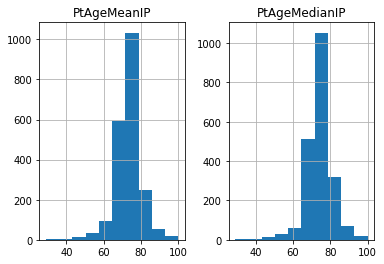

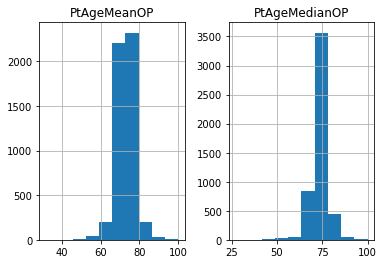

In [196]:
# Do we need an IP/OP split? No.

feat_age_ip.hist()
plt.show()

feat_age_op.hist()
plt.show()

In [189]:
# Making final feature

feat_age_final = flags.merge(feat_age_ipop, how='left', on='Provider')
print(len(feat_age_final))
feat_age_final.head()

5410


,Provider,PotentialFraud,PtAgeMedian,PtAgeMean
0,PRV51001,No,79.0,77.880000
1,PRV51003,Yes,71.0,69.083333
2,PRV51004,No,72.0,71.261745
3,PRV51005,Yes,70.0,69.526180
4,PRV51007,No,69.5,68.305556


## Number of Pts

In [198]:
feat_patients_ip = pd.DataFrame(ip.groupby('Provider')['BeneID'].nunique()).rename(columns={'BeneID':'NumPtsIP'}).reset_index()
feat_patients_op = pd.DataFrame(op.groupby('Provider')['BeneID'].nunique()).rename(columns={'BeneID':'NumPtsOP'}).reset_index()
feat_patients_ipop = pd.DataFrame(op.groupby('Provider')['BeneID'].nunique()).rename(columns={'BeneID':'NumPts'}).reset_index()
feat_patients_ip.head()

,Provider,NumPtsIP
0,PRV51001,5
1,PRV51003,53
2,PRV51007,3
3,PRV51008,2
4,PRV51011,1


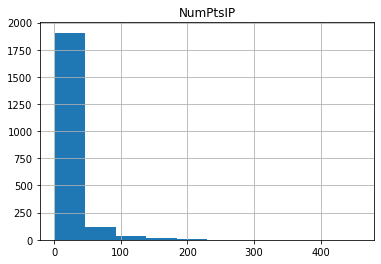

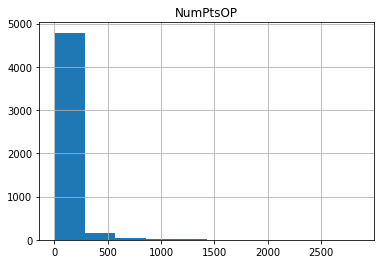

In [199]:
# Do we need an IP/OP split? Yes.

feat_patients_ip.hist()
plt.show()

feat_patients_op.hist()
plt.show()

In [200]:
# Making final feature

feat_patients_final = flags.merge(feat_patients_ip, how='left', on='Provider')
feat_patients_final = feat_patients_final.merge(feat_patients_op, how='left', on='Provider')

print(len(feat_patients_final))
feat_patients_final.head()

5410


,Provider,PotentialFraud,NumPtsIP,NumPtsOP
0,PRV51001,No,5.0,19.0
1,PRV51003,Yes,53.0,66.0
2,PRV51004,No,NaN,138.0
3,PRV51005,Yes,NaN,495.0
4,PRV51007,No,3.0,56.0


## States Served

In [201]:
feat_states_ip = pd.DataFrame(ip.groupby('Provider')['State'].nunique()).rename(columns={'State':'NumStatesIP'}).reset_index()
feat_states_op = pd.DataFrame(op.groupby('Provider')['State'].nunique()).rename(columns={'State':'NumStatesOP'}).reset_index()
feat_states_ipop = pd.DataFrame(op.groupby('Provider')['State'].nunique()).rename(columns={'State':'NumStates'}).reset_index()
feat_states_ip.head()


,Provider,NumStatesIP
0,PRV51001,1
1,PRV51003,3
2,PRV51007,1
3,PRV51008,1
4,PRV51011,1


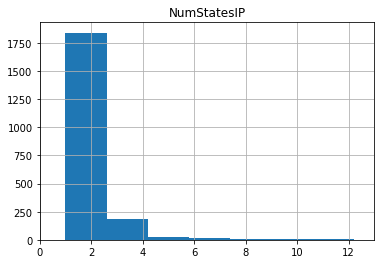

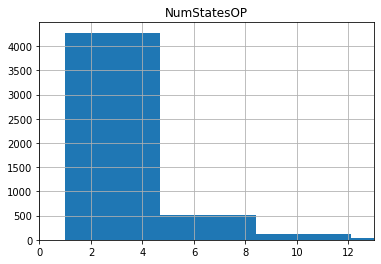

Ttest_indResult(statistic=-15.371409811239857, pvalue=1.7697718514496237e-52)

In [207]:
# Do we need an IP/OP split? Yes.

feat_states_ip.hist()
plt.xlim(0,13)
plt.show()

feat_states_op.hist()
plt.xlim(0,13)
plt.show()

from scipy import stats

stats.ttest_ind(feat_states_ip['NumStatesIP'], feat_states_op['NumStatesOP'])

In [208]:
# Making final feature

feat_states_final = flags.merge(feat_states_ip, how='left', on='Provider')
feat_states_final = feat_states_final.merge(feat_states_op, how='left', on='Provider')

print(len(feat_states_final))
feat_states_final.head()

5410


,Provider,PotentialFraud,NumStatesIP,NumStatesOP
0,PRV51001,No,1.0,1.0
1,PRV51003,Yes,3.0,3.0
2,PRV51004,No,NaN,9.0
3,PRV51005,Yes,NaN,4.0
4,PRV51007,No,1.0,2.0


## Merge All

In [211]:
from functools import reduce

full_ip = reduce(lambda x,y: pd.merge(x,y, on='Provider', how='outer'), [feat_duration_ip, feat_both_ip, feat_conditions_ip,feat_age_ip,feat_patients_ip,feat_states_ip])
full_op = reduce(lambda x,y: pd.merge(x,y, on='Provider', how='outer'), [feat_duration_op, feat_both_op, feat_conditions_op,feat_age_op,feat_patients_op,feat_states_op])
full_ipop = reduce(lambda x,y: pd.merge(x,y, on='Provider', how='outer'), [feat_duration_ipop, feat_both_ipop, feat_conditions_ipop,feat_age_ipop,feat_patients_ipop,feat_states_ipop])

full_final = reduce(lambda x,y: pd.merge(x,y, on=['Provider','PotentialFraud'], how='outer'), [feat_duration_final, feat_both_final, feat_conditions_final,feat_age_final,feat_patients_final,feat_states_final])



In [213]:
print(len(full_final))
full_final.head()

5410


,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP
0,PRV51001,No,4.0,5.000000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0
1,PRV51003,Yes,4.0,5.161290,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0
2,PRV51004,No,NaN,NaN,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,NaN,138.0,NaN,9.0
3,PRV51005,Yes,NaN,NaN,0.0,1.088412,OP,7.0,6.886695,5.0,70.0,69.526180,NaN,495.0,NaN,4.0
4,PRV51007,No,5.0,5.333333,0.0,0.768116,Both,7.0,6.986111,6.0,69.5,68.305556,3.0,56.0,1.0,2.0


## Analysis of Full Final Table

In [216]:
full_final.isna().sum()

Provider               0
PotentialFraud         0
DurationMedianIP    3318
DurationMeanIP      3318
DurationMedianOP     398
DurationMeanOP       398
Serves                 0
ChronCondsMedian       0
ChronCondsMean         0
ChronConsMode          0
PtAgeMedian            0
PtAgeMean              0
NumPtsIP            3318
NumPtsOP             398
NumStatesIP         3318
NumStatesOP          398
dtype: int64

In [217]:
full_final.Serves.value_counts()

OP      3318
Both    1694
IP       398
Name: Serves, dtype: int64